<a href="https://colab.research.google.com/github/marcforto14/Music-Detection-System/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training script
The following script reads the audio tracks  from the MUSPEAK dataset, it divides each track into frames and obtains the first 13 MFCC coefficients. This is then saved in a .csv file in order to train the SVM model. The trained model is also saved in a .pkl file.

## Import libraries and mount Drive



In [ ]:
!pip install essentia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import essentia.standard as es
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import audio tracks, obtain MFCCs and save to csv
As each track corresponds solely to one class, we can save each frame in a dataframe with its corresponding label. This block must firstly be run with the musan/speech files, and then with the musan/music files.

In [ ]:
sr = 44100
frame_length =  16384
step_size = int(frame_length/2)

music_dir = '/content/drive/MyDrive/ColabNotebooks/musan/music/'
speech_dir = '/content/drive/MyDrive/ColabNotebooks/musan/speech/'

logNorm = es.UnaryOperator(type='log')
mfcc = es.MFCC()
spectrum = es.Spectrum()
w = es.Windowing(type='hann')

dfm = pd.DataFrame()
for track in os.listdir(speech_dir):
  audio_loader = es.MonoLoader(filename=(speech_dir + track), sampleRate=44100)
  audio=audio_loader()
  for frame in es.FrameGenerator(audio, frameSize = frame_length, hopSize = step_size, startFromZero=True):
    #Features extraction
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    #Svae features to dataframe
    df2 = pd.DataFrame({"class":["s"],"mfcc1":[mfcc_coeffs[0]],"mfcc2":[mfcc_coeffs[1]],"mfcc3":[mfcc_coeffs[2]],
                        "mfcc4":[mfcc_coeffs[3]],"mfcc5":[mfcc_coeffs[4]],"mfcc6":[mfcc_coeffs[5]],
                        "mfcc7":[mfcc_coeffs[6]],"mfcc8":[mfcc_coeffs[7]],"mfcc9":[mfcc_coeffs[8]],
                        "mfcc10":[mfcc_coeffs[9]],"mfcc11":[mfcc_coeffs[10]],"mfcc12":[mfcc_coeffs[11]],
                        "mfcc13":[mfcc_coeffs[12]]})
    dfm = dfm.append(df2, ignore_index=True)

In [ ]:
dfm.shape[0]

144685

In [ ]:
from pathlib import Path
dfPath = Path('/content/drive/MyDrive/ColabNotebooks/speech_mfcc_training_data.csv')
# dfPath = Path('/content/drive/MyDrive/ColabNotebooks/music_mfcc_training_data.csv')

dfm.to_csv(dfPath,index=False)

## Load training data and select frames for training

In [ ]:
import math

train_data_size = 250000
dfmi = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/music_mfcc_training_data.csv')
dfsi = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/speech_mfcc_training_data.csv')
np.random.seed(10)
n_rm_music = dfmi.shape[0]-int(train_data_size/2)
n_rm_speech = dfsi.shape[0]-int(train_data_size/2)
i_rm_music = np.random.choice(dfmi.index, n_rm_music, replace=False)
i_rm_speech = np.random.choice(dfsi.index, n_rm_speech, replace=False)
dfmi = dfmi.drop(i_rm_music)
dfsi = dfsi.drop(i_rm_speech)
dfall = dfmi.append(dfsi)
df_filtered = dfall[dfall['mfcc1'] >= -980]

## SVM fitting and saving

In [ ]:
# Fast model using LinearSVC
from sklearn import svm
import joblib
X = dfall.drop('class',axis=1)
X = X.drop('mfcc1',axis=1)
y = dfall['class']
clf = svm.LinearSVC(dual=False)
clf.fit(X,y)
joblib.dump(clf,'/content/drive/MyDrive/ColabNotebooks/svm_model_4.pkl',compress=9)

['/content/drive/MyDrive/ColabNotebooks/svm_model_4.pkl']

In [ ]:
# Model using normal SVC
from sklearn import svm
import joblib
X = dfall.drop('class',axis=1)
X = X.drop('mfcc1',axis=1)
y = dfall['class']
clf = svm.SVC(kernel='linear')
clf.fit(X,y)
joblib.dump(clf,'/content/drive/MyDrive/ColabNotebooks/svm_model_3.pkl',compress=9)

## Playing with the model

In [ ]:
def max_voting_filter(signal,window):
    # Convert signal characters to integers
    signal = [ord(c) for c in signal]
    
    # Define the window size
    window_size = window
    
    # Define the maximum number of neighbors to consider for voting
    num_neighbors = int((window_size - 1) / 2)
    
    # Initialize an empty list to hold the filtered signal
    filtered_signal = []
    
    # Loop over the signal
    for i in range(len(signal)):
        # Find the starting and ending indices for the current window
        start_idx = max(0, i - num_neighbors)
        end_idx = min(len(signal) - 1, i + num_neighbors)
        
        # Extract the values in the current window
        window_vals = signal[start_idx:end_idx+1]
        
        # Compute the mode of the window
        mode_val = chr(np.argmax(np.bincount(window_vals)))
        
        # Append the mode value to the filtered signal
        filtered_signal.append(mode_val)
    
    # Convert filtered signal back to string
    # filtered_signal = ''.join(filtered_signal)
    
    return filtered_signal

In [ ]:
# Obtain testing data from wav file
step_size = int(frame_length/2)
audio_loader = es.MonoLoader(filename='/content/drive/MyDrive/ColabNotebooks/muspeak/track006.mp3')
audio_test = audio_loader()
mfcc = es.MFCC()
spectrum = es.Spectrum()
w = es.Windowing(type='hann')
x_test = pd.DataFrame()
for frame in es.FrameGenerator(audio_test, frameSize = frame_length, hopSize = step_size, startFromZero=True):
  mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
  df = pd.DataFrame({"mfcc2":[mfcc_coeffs[1]],"mfcc3":[mfcc_coeffs[2]],
                      "mfcc4":[mfcc_coeffs[3]],"mfcc5":[mfcc_coeffs[4]],"mfcc6":[mfcc_coeffs[5]],
                      "mfcc7":[mfcc_coeffs[6]],"mfcc8":[mfcc_coeffs[7]],"mfcc9":[mfcc_coeffs[8]],
                      "mfcc10":[mfcc_coeffs[9]],"mfcc11":[mfcc_coeffs[10]],"mfcc12":[mfcc_coeffs[11]],
                      "mfcc13":[mfcc_coeffs[12]]})
  x_test = x_test.append(df, ignore_index=True)

In [ ]:
# Import model and predict
model = joblib.load('/content/drive/MyDrive/ColabNotebooks/svm_model_4.pkl')
y_test = model.predict(x_test)

In [ ]:
ground_truth = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/muspeak/labeled_track006.csv')

in_array = y_test
out_array = max_voting_filter(in_array, 10)

pp_signal_ = pd.DataFrame(out_array)
pp_signal = pp_signal_[0].to_numpy()

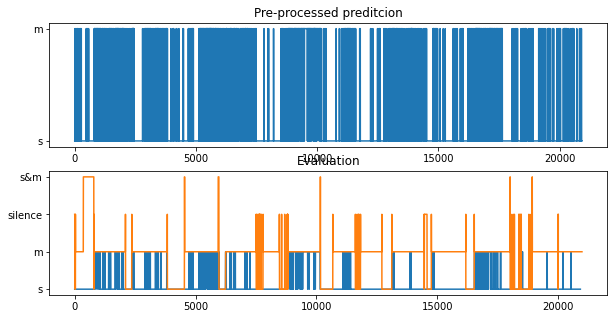

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
ax1.plot(in_array)
ax1.set_title('Pre-processed preditcion')
ax2.plot(pp_signal)
ax2.set_title('Evaluation')
ax2.plot(ground_truth["class"].to_numpy())
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
df_res = pd.concat([pp_signal_[:20924], ground_truth["class"]], axis=1)
df_res = df_res[df_res['class'] != 'silence']
df_res = df_res[df_res['class'] != 's&m']
# accuracy_score(df_res['class'], df_res[0])
f1_score(df_res['class'], df_res[0],average='weighted')
# f1_score(ground_truth['class'], pp_signal_[:19083],average='weighted')

TypeError: ignored

In [ ]:
df_res.head()

,0,class
12,s,s
13,s,s
14,s,s
15,s,s
16,s,s


In [ ]:
frame_length =  16384
step_size = int(frame_length/2)
mfcc = es.MFCC()
spectrum = es.Spectrum()
w = es.Windowing(type='hann')
model = joblib.load('/content/drive/MyDrive/ColabNotebooks/svm_model_4.pkl')
y_test = pd.DataFrame()
ground_truth = pd.DataFrame()
music_dir = '/content/drive/MyDrive/ColabNotebooks/muspeak/'
for track in os.listdir(music_dir):
  if track.startswith('track') and track.endswith('.mp3'):
    x_test = pd.DataFrame()
    audio_loader = es.MonoLoader(filename=(music_dir + track))
    audio = audio_loader()
    for frame in es.FrameGenerator(audio, frameSize = frame_length, hopSize = step_size, startFromZero=True):
      mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
      df = pd.DataFrame({"mfcc2":[mfcc_coeffs[1]],"mfcc3":[mfcc_coeffs[2]],
                          "mfcc4":[mfcc_coeffs[3]],"mfcc5":[mfcc_coeffs[4]],"mfcc6":[mfcc_coeffs[5]],
                          "mfcc7":[mfcc_coeffs[6]],"mfcc8":[mfcc_coeffs[7]],"mfcc9":[mfcc_coeffs[8]],
                          "mfcc10":[mfcc_coeffs[9]],"mfcc11":[mfcc_coeffs[10]],"mfcc12":[mfcc_coeffs[11]],
                          "mfcc13":[mfcc_coeffs[12]]})
      x_test = x_test.append(df, ignore_index=True)
    # predict
    y_test_iter = model.predict(x_test)
    # post process
    pp_y_test_iter = pd.DataFrame(max_voting_filter(y_test_iter, 50))
    # Load labeled data from csv (ground truth)
    name, ext = os.path.splitext(track)
    gt = pd.read_csv(music_dir + "labeled_" + name + ".csv")
    # append to global varialbes
    if(pp_y_test_iter.shape[0]>gt.shape[0]):
      ground_truth = ground_truth.append(gt)
      y_test = y_test.append(pp_y_test_iter[0:gt.shape[0]])

# Metrics from y_test and ground_truth

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
df_res = pd.concat([y_test, ground_truth["class"]], axis=1)
df_res = df_res[df_res['class'] != 'silence']
df_res = df_res[df_res['class'] != 's&m']
# accuracy_score(df_res['class'], df_res[0])
f1_score(df_res['class'], df_res[0],average='weighted')
# df_res.head()

0.2863178146986922

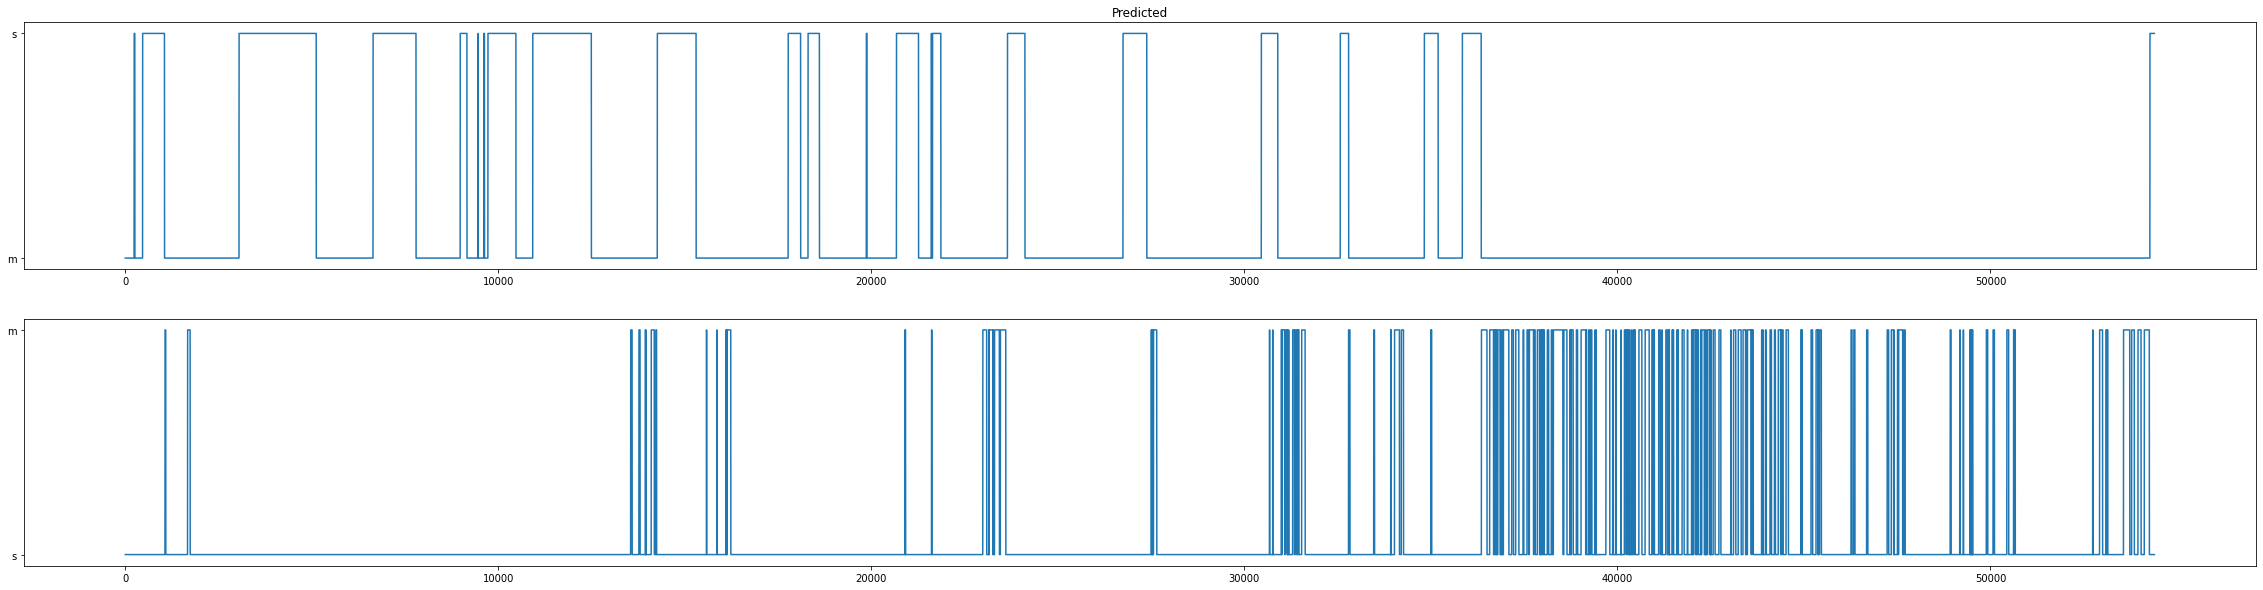

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 10))
ax1.plot(df_res['class'].to_numpy())
ax2.plot(df_res[0].to_numpy())
ax1.set_title('Predicted')
plt.show()